**READING PATIENT SAMPLES AND COMBINING THEM ACCORDING TO FEATURES**

In [1]:
import os
import pandas as pd
import numpy as np

# === Settings ===
data_dir = r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\csv_converted_files\Train_Test_Subjects"  # path where your CSVs are stored
window_size = 128
stride = 64

feature_cols = [
    "ankle_x", "ankle_y", "ankle_z",
    "thigh_x", "thigh_y", "thigh_z",
    "trunk_x", "trunk_y", "trunk_z"
]

X_all = []
y_all = []

# === Process all .csv files ===
for filename in os.listdir(data_dir):
    if filename.endswith(".csv"):
        df = pd.read_csv(os.path.join(data_dir, filename))

        # Sliding window per file
        for start in range(0, len(df) - window_size + 1, stride):
            end = start + window_size
            window = df.iloc[start:end]
            x_window = window[feature_cols].values
            label = 1 if 1 in window["label"].values else 0
            X_all.append(x_window)
            y_all.append(label)

X_all = np.array(X_all)
y_all = np.array(y_all)

print("Done")
print("X_all.shape =", X_all.shape)
print("y_all.shape =", y_all.shape)

Done
X_all.shape = (24230, 128, 9)
y_all.shape = (24230,)


**NORMALIZING FEATURES**

In [2]:
# === Step 4: Normalize the Data (z-score normalization) ===
# Compute mean and std over all samples and all timepoints
mean = X_all.mean(axis=(0, 1))  # shape: (9,)
std = X_all.std(axis=(0, 1)) + 1e-8  # prevent division by zero

# Apply normalization
X_norm = (X_all - mean) / std

print("Data normalized.")
print("X_norm shape:", X_norm.shape)

Data normalized.
X_norm shape: (24230, 128, 9)


**GRAPHICAL REPRESENTATION OF EACH FEATURE BEFORE AND AFTER NORMALIZING**

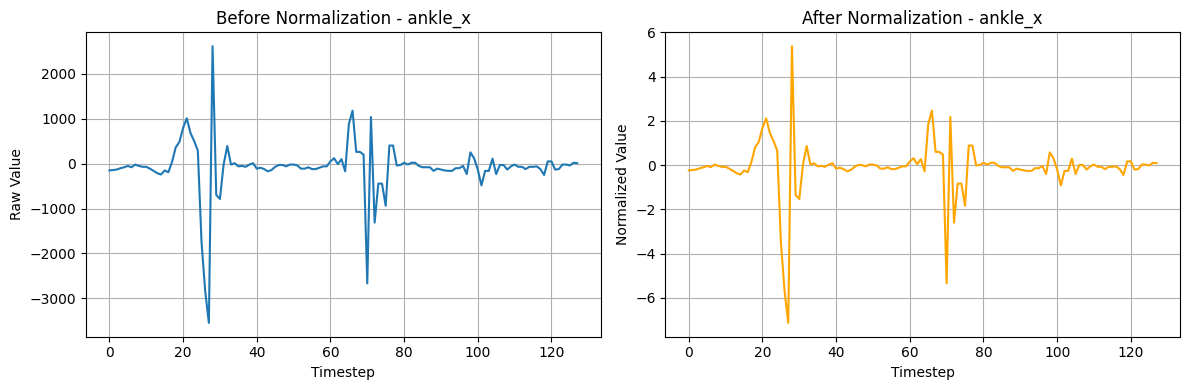

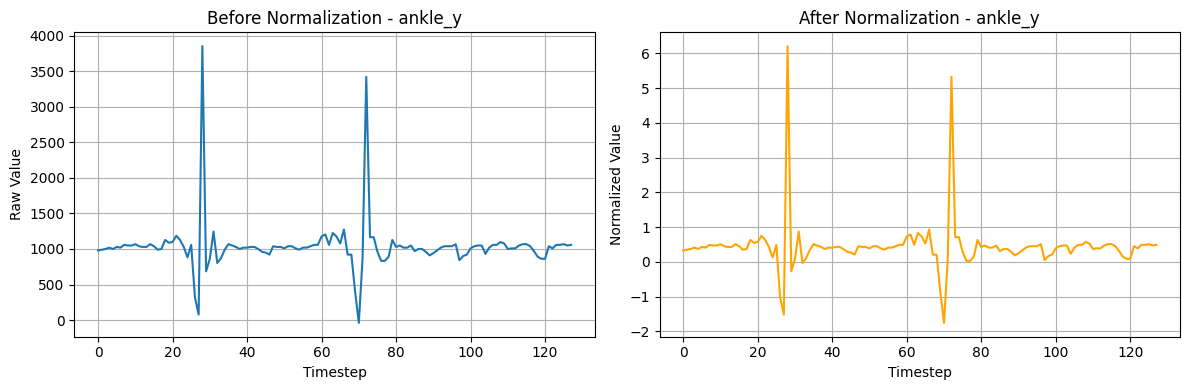

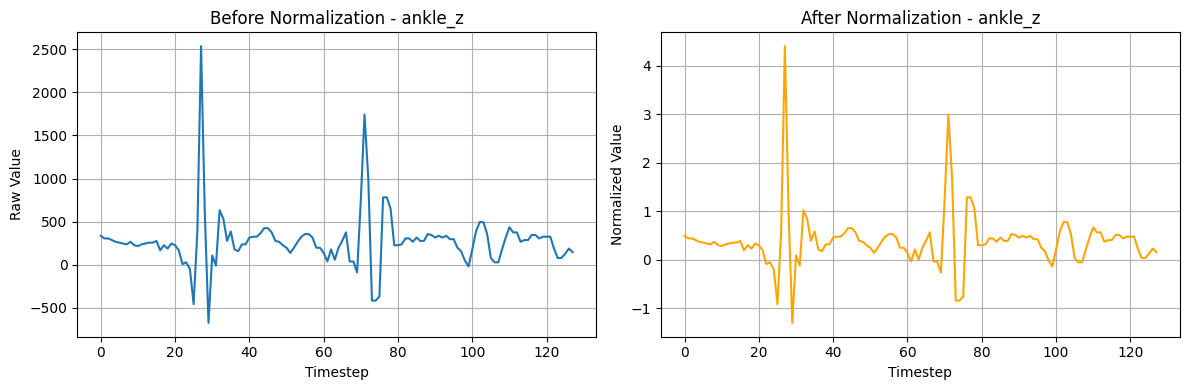

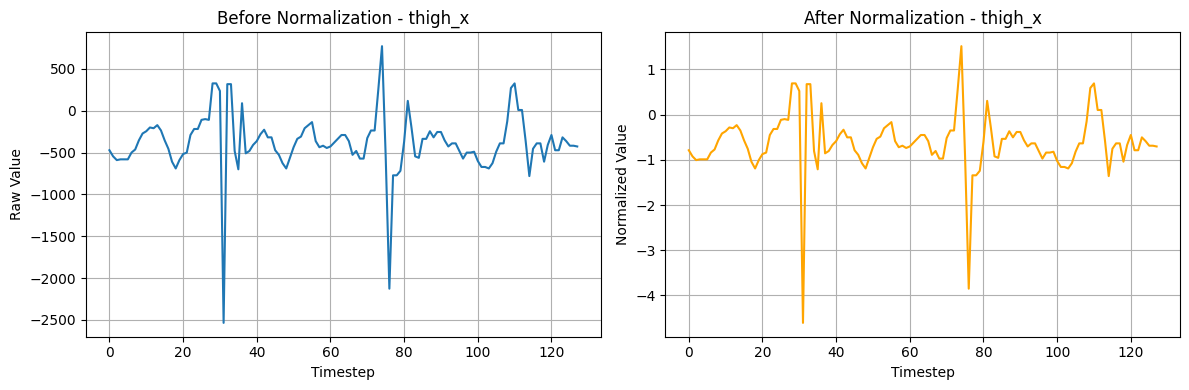

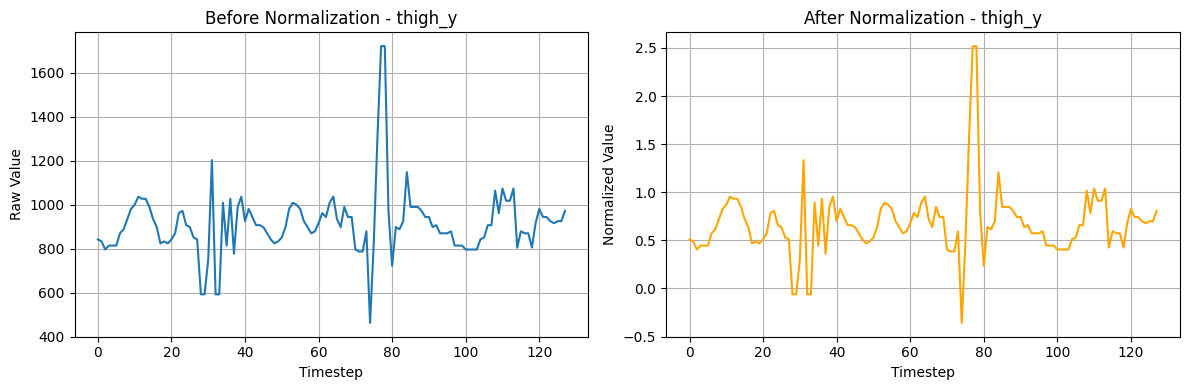

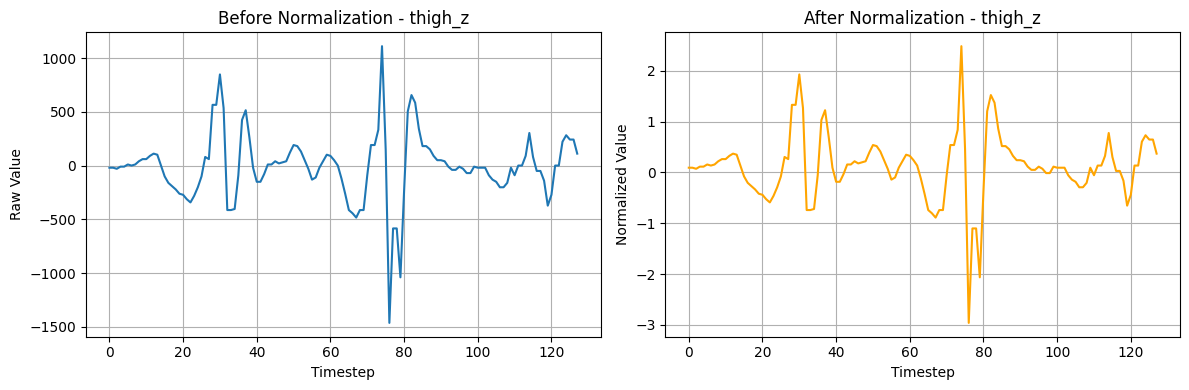

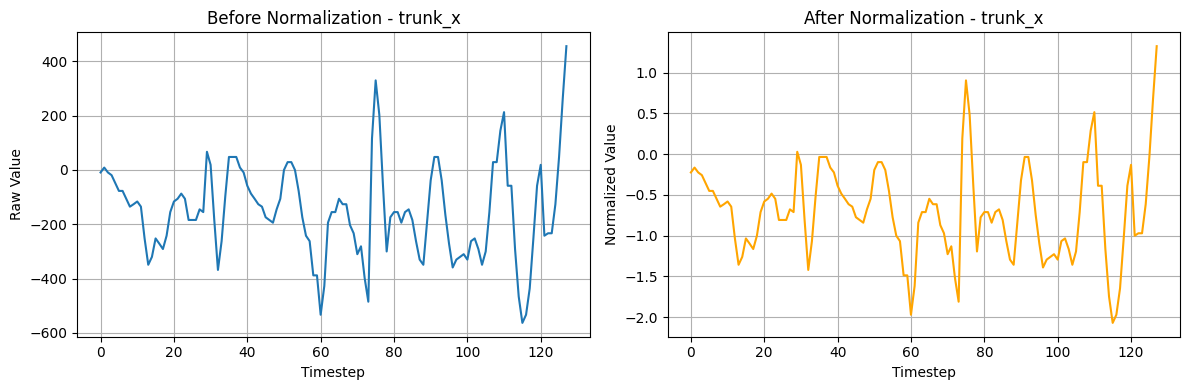

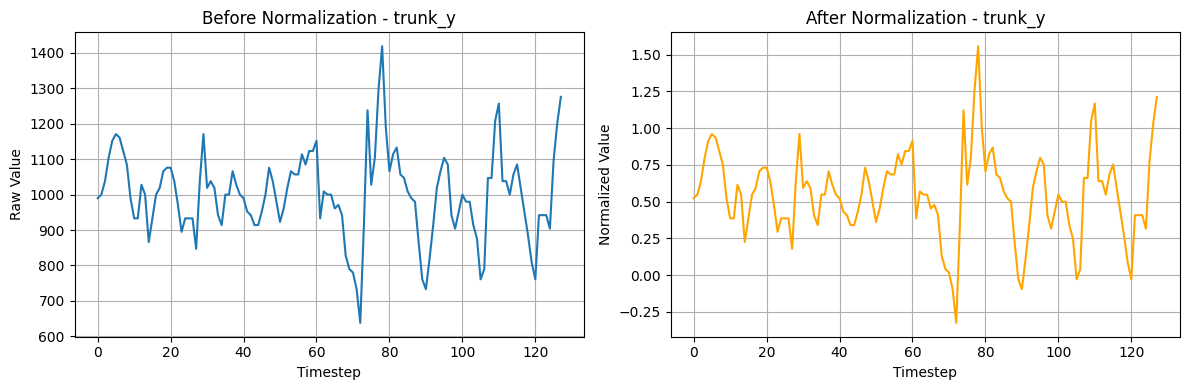

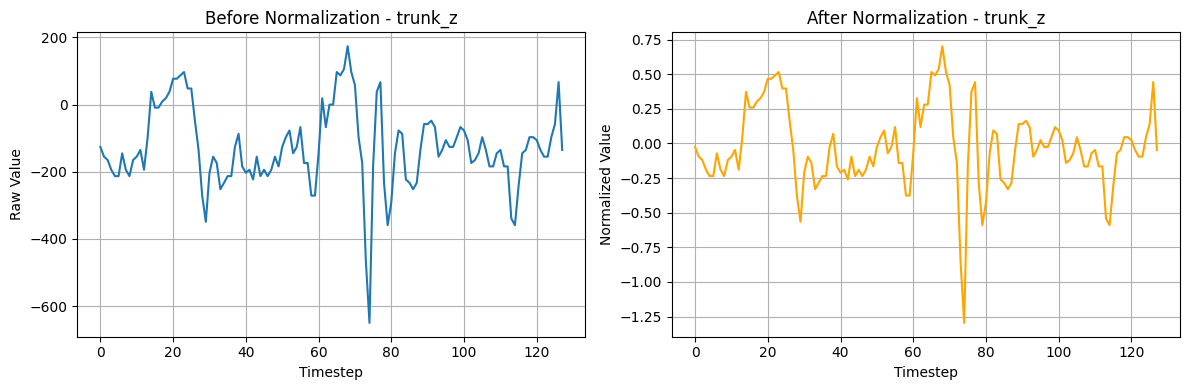

In [3]:
import matplotlib.pyplot as plt
import random

# === Feature names for labeling ===
feature_names = [
    "ankle_x", "ankle_y", "ankle_z",
    "thigh_x", "thigh_y", "thigh_z",
    "trunk_x", "trunk_y", "trunk_z"
]

# === Pick a random sample index ===
idx = random.randint(0, X_all.shape[0] - 1)

# === Loop through all 9 features ===
for feature_idx, feature_name in enumerate(feature_names):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(X_all[idx, :, feature_idx], label='Original')
    plt.title(f"Before Normalization - {feature_name}")
    plt.xlabel("Timestep")
    plt.ylabel("Raw Value")
    plt.grid(True)

    plt.subplot(1, 2, 2)
    plt.plot(X_norm[idx, :, feature_idx], color='orange', label='Normalized')
    plt.title(f"After Normalization - {feature_name}")
    plt.xlabel("Timestep")
    plt.ylabel("Normalized Value")
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [4]:
# === For the original DataFrame (Pandas) ===
print("-----------------------------First 10 rows of the original DataFrame (df):----------------------------------------")
print(df.head(10))
print("\n" + "="*60 + "\n")

# === For the raw NumPy array before normalization ===
print("-----------------------------First 10 samples from X_all (before normalization):----------------------------------")
print(X_all[:10])
print("\n" + "="*60 + "\n")

# === For the normalized NumPy array ===
print("-----------------------------First 10 samples from X_norm (after normalization):----------------------------------")
print(X_norm[:10])

-----------------------------First 10 rows of the original DataFrame (df):----------------------------------------
   timestamp  ankle_x  ankle_y  ankle_z  thigh_x  thigh_y  thigh_z  trunk_x  \
0         15        0        0        0      127       37     -969        0   
1         31        0        0        0      127       37     -969        0   
2         46       70       39     -970      100       55     -969        0   
3         62       70       39     -970      109       46     -969        0   
4         78       70       39     -980      109       46     -969        0   
5         93       70       39     -980      109       64     -979        0   
6        109       70       39     -970      118       46     -969        0   
7        125       70       49     -980      109       64     -969        0   
8        140       70       49     -980      109       64     -969        0   
9        156       70       29     -970      100       55     -969        0   

   trunk_y  tru

**SAVING THE COMBINED TRAINING DATASET**

In [6]:
import os
import pandas as pd
import numpy as np

# === Flatten the (128, 9) samples ===
X_flat = X_all.reshape(X_all.shape[0], -1)

# === Create DataFrame and append labels ===
df = pd.DataFrame(X_flat)
df["label"] = y_all

# === Designated output folder ===
output_dir = r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\csv_converted_files"
os.makedirs(output_dir, exist_ok=True)  # Create if not exist

# === Save to CSV ===
output_path = os.path.join(output_dir, "Xy_train_combined_1-8.csv")
df.to_csv(output_path, index=False)

print(f"Saved as {output_path}")

Saved as G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\csv_converted_files\Xy_train_combined_1-8.csv


In [7]:
#### JUST IN CASE WE NEEDED TO READ ANY TRAINING FILE AND CONVERT IT TO USABLE FORMAT ####

# === Step 1: Load the CSV ===
#df = pd.read_csv(r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\csv_converted_files\Xy_train_combined_1-8.csv")

# === Step 2: Split features and labels ===
#X_flat = df.drop(columns=["label"]).values  # shape: (n_samples, 1152)
#y = df["label"].values                      # shape: (n_samples,)

# === Step 3: Reshape to 3D (128, 9) for CNN input ===
#X = X_flat.reshape(-1, 128, 9)

#print("Data reshaped:")
#print("X shape:", X.shape)
#print("y shape:", y.shape)

**CONNECTION TO GPU**

In [8]:
import torch

if torch.cuda.is_available():
  device = 'cuda'
else:
  device = 'cpu'

print(device)

cuda


In [9]:
X = X_norm
y = y_all


print(X_norm.shape)
print(y_all.shape)

(24230, 128, 9)
(24230,)


**TRAINING AND HYPERPARAMETER TUNING OF PYTORCH MODEL**

In [10]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# === INCASE WE NEEDED TO LOAD DATASET ===
#df = pd.read_csv(r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\csv_converted_files\Xy_train_combined_1-8.csv")
#X = df.drop(columns=["label"]).values.reshape(-1, 128, 9)
#y = df["label"].values





X_tensor = torch.tensor(X_norm, dtype=torch.float32) #Here X is used instead of X_norm if dataset is loaded
y_tensor = torch.tensor(y_all, dtype=torch.float32)  #Here y is used instead of y_all if dataset is loaded

dataset = TensorDataset(X_tensor, y_tensor)
train_len = int(len(dataset) * 0.85)
val_len = len(dataset) - train_len
train_ds, val_ds = random_split(dataset, [train_len, val_len])

# === Hyperparameter grid ===
param_grid = {
    "filters1": [32, 64],
    "filters2": [64, 128],
    "kernel_size": [3, 5],
    "dropout": [0.3, 0.5],
    "lr": [0.001, 0.0005]
}

# === Model definition ===
class GaitCNN(nn.Module):
    def __init__(self, filters1, filters2, kernel_size, dropout):
        super(GaitCNN, self).__init__()
        self.conv1 = nn.Conv1d(9, filters1, kernel_size=kernel_size)
        self.bn1 = nn.BatchNorm1d(filters1)
        self.pool1 = nn.MaxPool1d(2)

        self.conv2 = nn.Conv1d(filters1, filters2, kernel_size=kernel_size)
        self.bn2 = nn.BatchNorm1d(filters2)
        self.pool2 = nn.MaxPool1d(2)

        self.global_avg_pool = nn.AdaptiveAvgPool1d(1)
        self.dropout = nn.Dropout(dropout)
        self.fc1 = nn.Linear(filters2, 64)
        self.fc2 = nn.Linear(64, 1)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, channels, length)
        x = self.pool1(torch.relu(self.bn1(self.conv1(x))))
        x = self.pool2(torch.relu(self.bn2(self.conv2(x))))
        x = self.global_avg_pool(x).squeeze(-1)
        x = self.dropout(torch.relu(self.fc1(x)))
        return torch.sigmoid(self.fc2(x)).squeeze(-1)

# === Grid Search ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_f1 = 0
best_params = {}
best_model_state = None
best_y_true, best_y_pred = [], []

for f1 in param_grid["filters1"]:
    for f2 in param_grid["filters2"]:
        for ks in param_grid["kernel_size"]:
            for dr in param_grid["dropout"]:
                for lr in param_grid["lr"]:
                    print(f"Training: filters1={f1}, filters2={f2}, ks={ks}, dropout={dr}, lr={lr}")
                    model = GaitCNN(f1, f2, ks, dr).to(device)
                    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
                    criterion = nn.BCELoss()
                    train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
                    val_loader = DataLoader(val_ds, batch_size=32)

                    for epoch in range(30):  # keep small for tuning
                        model.train()
                        for xb, yb in train_loader:
                            xb, yb = xb.to(device), yb.to(device)
                            pred = model(xb)
                            loss = criterion(pred, yb)
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

                    # Evaluate
                    model.eval()
                    y_true, y_pred = [], []
                    with torch.no_grad():
                        for xb, yb in val_loader:
                            xb = xb.to(device)
                            pred = model(xb)
                            y_true.extend(yb.cpu().numpy())
                            y_pred.extend((pred.cpu().numpy() > 0.5).astype(int))

                    f1_val = f1_score(y_true, y_pred)
                    print(f"F1 = {f1_val:.4f}")
                    if f1_val > best_f1:
                        best_f1 = f1_val
                        best_params = {"filters1": f1, "filters2": f2, "kernel_size": ks, "dropout": dr, "lr": lr}
                        best_model_state = model.state_dict()
                        best_y_true = y_true
                        best_y_pred = y_pred

# === Final Evaluation ===
print(" Best F1-score:", best_f1)
print(" Best Parameters:", best_params)






Training: filters1=32, filters2=64, ks=3, dropout=0.3, lr=0.001
F1 = 0.8954
Training: filters1=32, filters2=64, ks=3, dropout=0.3, lr=0.0005
F1 = 0.8819
Training: filters1=32, filters2=64, ks=3, dropout=0.5, lr=0.001
F1 = 0.8776
Training: filters1=32, filters2=64, ks=3, dropout=0.5, lr=0.0005
F1 = 0.8895
Training: filters1=32, filters2=64, ks=5, dropout=0.3, lr=0.001
F1 = 0.8832
Training: filters1=32, filters2=64, ks=5, dropout=0.3, lr=0.0005
F1 = 0.8844
Training: filters1=32, filters2=64, ks=5, dropout=0.5, lr=0.001
F1 = 0.8882
Training: filters1=32, filters2=64, ks=5, dropout=0.5, lr=0.0005
F1 = 0.8925
Training: filters1=32, filters2=128, ks=3, dropout=0.3, lr=0.001
F1 = 0.8978
Training: filters1=32, filters2=128, ks=3, dropout=0.3, lr=0.0005
F1 = 0.8909
Training: filters1=32, filters2=128, ks=3, dropout=0.5, lr=0.001
F1 = 0.8896
Training: filters1=32, filters2=128, ks=3, dropout=0.5, lr=0.0005
F1 = 0.8834
Training: filters1=32, filters2=128, ks=5, dropout=0.3, lr=0.001
F1 = 0.8836
T

**REPRESENTING RESULTS FROM THE BEST PYTORCH MODEL**

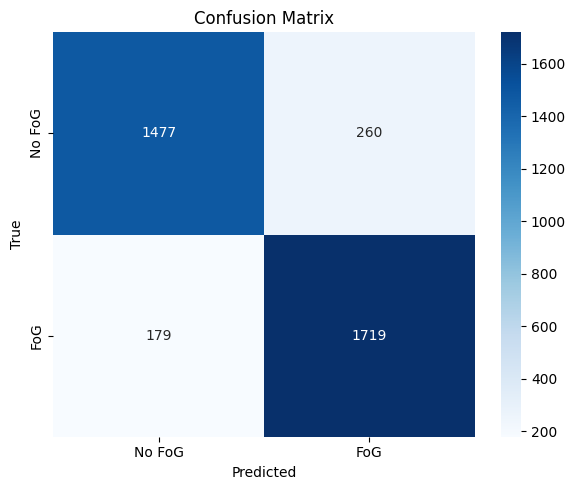

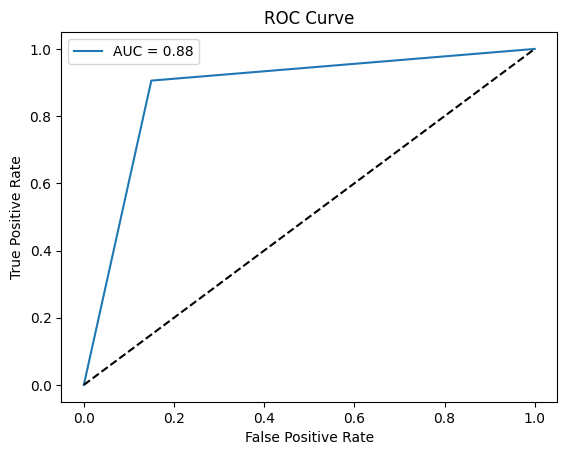

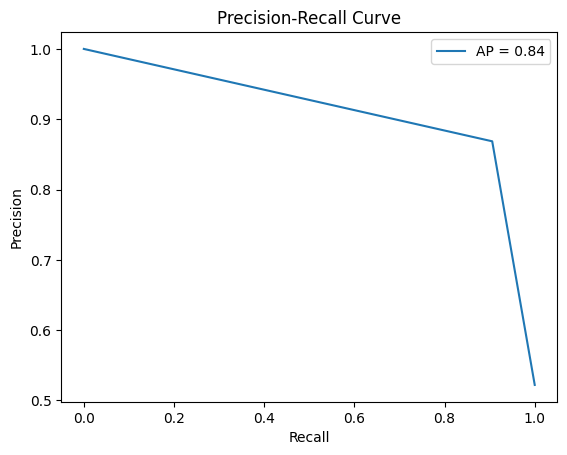

In [11]:

from sklearn.metrics import roc_curve, auc




# Corrected model loading
model_params = {k: v for k, v in best_params.items() if k != "lr"}

final_model = GaitCNN(**model_params).to(device)
final_model.load_state_dict(best_model_state)



# Compute confusion matrix
matrix = confusion_matrix(y_true, y_pred)

# Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["No FoG", "FoG"], yticklabels=["No FoG", "FoG"])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()






fpr, tpr, _ = roc_curve(y_true, y_pred)  # y_prob = model outputs before thresholding
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')  # baseline
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(y_true, y_pred)
ap = average_precision_score(y_true, y_pred)

plt.plot(recall, precision, label=f'AP = {ap:.2f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [12]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

metrics = {
    "Accuracy": accuracy_score(y_true, y_pred),
    "Precision": precision_score(y_true, y_pred),
    "Recall": recall_score(y_true, y_pred),
    "F1 Score": f1_score(y_true, y_pred),
    "AUC": roc_auc
}
for k, v in metrics.items():
    print(f"{k}: {v:.4f}")

Accuracy: 0.8792
Precision: 0.8686
Recall: 0.9057
F1 Score: 0.8868
AUC: 0.8780


**PREPROCESSING THE GENERALIZATION SUBJECT**

In [13]:
import pandas as pd
import numpy as np
import torch

# === Load generalization subject (S10) ===
df = pd.read_csv(r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\csv_converted_files\Generalization Subjects\S10R01.csv")



# === Parameters ===
window_size = 128
stride = 64
feature_cols = [
    "ankle_x", "ankle_y", "ankle_z",
    "thigh_x", "thigh_y", "thigh_z",
    "trunk_x", "trunk_y", "trunk_z"
]

X_gen = []
y_gen = []

for start in range(0, len(df) - window_size + 1, stride):
    end = start + window_size
    window = df.iloc[start:end]
    x_window = window[feature_cols].values
    label = 1 if 1 in window["label"].values else 0

    # Normalize using training mean/std
    x_window_norm = (x_window - mean) / std
    X_gen.append(x_window_norm)
    y_gen.append(label)

# === Convert to tensors for model inference ===
X_gen = np.array(X_gen)
y_gen = np.array(y_gen)

X_gen_tensor = torch.tensor(X_gen, dtype=torch.float32).to(device)
y_gen_tensor = torch.tensor(y_gen, dtype=torch.float32)

print("Generalization subject prepared and normalized.")
print("X_gen_tensor shape:", X_gen_tensor.shape)
print("y_gen_tensor shape:", y_gen_tensor.shape)

Generalization subject prepared and normalized.
X_gen_tensor shape: torch.Size([3019, 128, 9])
y_gen_tensor shape: torch.Size([3019])


In [14]:
model.eval()
with torch.no_grad():
    y_pred = model(X_gen_tensor)
    y_pred_class = (y_pred.cpu().numpy() > 0.5).astype(int)

**RESULTS ON GENERALIZATION SUBJECT**

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.76      0.64       785
           1       0.90      0.78      0.84      2234

    accuracy                           0.78      3019
   macro avg       0.73      0.77      0.74      3019
weighted avg       0.81      0.78      0.79      3019

Confusion Matrix:
[[ 596  189]
 [ 487 1747]]


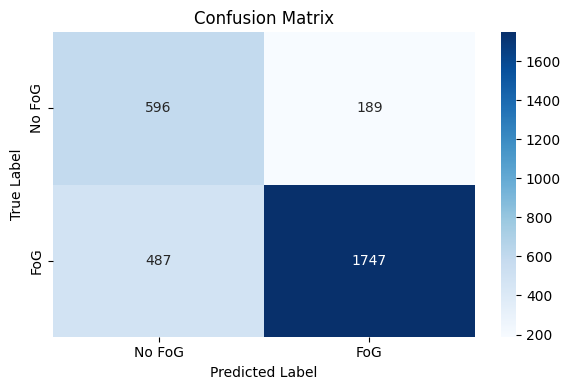

✅ Accuracy on generalization subject: 77.61%


In [15]:
from sklearn.metrics import classification_report, confusion_matrix
print("Classification Report:")
print(classification_report(y_gen, y_pred_class))

print("Confusion Matrix:")
print(confusion_matrix(y_gen, y_pred_class))

# === Confusion Matrix ===
cm = confusion_matrix(y_gen, y_pred_class)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No FoG", "FoG"], yticklabels=["No FoG", "FoG"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_gen, y_pred_class)
print(f"✅ Accuracy on generalization subject: {accuracy * 100:.2f}%")

**SAVING PYTORCH MODEL**

In [16]:
import torch
import os

# === Rebuild final model using best parameters ===
final_model = GaitCNN(
    filters1=best_params["filters1"],
    filters2=best_params["filters2"],
    kernel_size=best_params["kernel_size"],
    dropout=best_params["dropout"]
).to(device)

# Load the best trained weights
final_model.load_state_dict(best_model_state)
final_model.eval()

# === Export to TorchScript ===
example_input = torch.randn(1, 128, 9).to(device)  # (batch, seq_len, features)
traced_model = torch.jit.trace(final_model, example_input)

# === Specify your custom directory ===
export_dir = r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\Pytorch Model"
os.makedirs(export_dir, exist_ok=True)

# === Save the traced model ===
model_path = os.path.join(export_dir, "gait_fog_model_traced.pt")
torch.jit.save(traced_model, model_path)

print(f"✅ Saved to: {model_path}")

✅ Saved to: G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\Pytorch Model\gait_fog_model_traced.pt


**SAVING ONNX MODEL**

In [17]:
import torch
import os

# Make sure directory exists
onnx_dir = "G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\ONNX Model"
os.makedirs(onnx_dir, exist_ok=True)

# Set full ONNX path with filename
onnx_path = os.path.join(onnx_dir, "gait_model.onnx")

# Dummy input
dummy_input = torch.randn(1, 128, 9).to(device)

# Export ONNX
torch.onnx.export(
    final_model,
    dummy_input,
    onnx_path,
    input_names=["input"],
    output_names=["output"],
    dynamic_axes={"input": {0: "batch_size"}, "output": {0: "batch_size"}},
    opset_version=11
)

print(f"✅ Saved ONNX model to {onnx_path}")

<>:5: SyntaxWarning: invalid escape sequence '\M'
<>:5: SyntaxWarning: invalid escape sequence '\M'
C:\Users\User\AppData\Local\Temp\ipykernel_26588\3720641912.py:5: SyntaxWarning: invalid escape sequence '\M'
  onnx_dir = "G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\ONNX Model"


✅ Saved ONNX model to G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\ONNX Model\gait_model.onnx


**BUILDING A TENSORFLOW MODEL USING THE BEST MODEL PARAMETERS**

Epoch 1/30


c:\Users\User\.conda\envs\test\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


644/644 ━━━━━━━━━━━━━━━━━━━━ 7s 9ms/step - accuracy: 0.7765 - loss: 0.4328 - val_accuracy: 0.8256 - val_loss: 0.3621
Epoch 2/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8139 - loss: 0.3706 - val_accuracy: 0.8286 - val_loss: 0.3463
Epoch 3/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8259 - loss: 0.3512 - val_accuracy: 0.8322 - val_loss: 0.3399
Epoch 4/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.8321 - loss: 0.3340 - val_accuracy: 0.8468 - val_loss: 0.3199
Epoch 5/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8354 - loss: 0.3266 - val_accuracy: 0.8542 - val_loss: 0.3127
Epoch 6/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8374 - loss: 0.3231 - val_accuracy: 0.8528 - val_loss: 0.3039
Epoch 7/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.8456 - loss: 0.3084 - val_accuracy: 0.8495 - val_loss: 0.3039
Epoch 8/30
644/644 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8470 - loss: 0.3082 - val_accuracy: 0.8655 - val

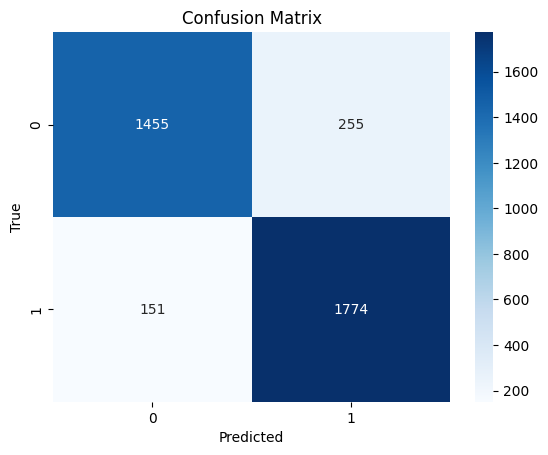

In [18]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, BatchNormalization, Dropout, GlobalAveragePooling1D, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# === Assume X_norm and y_all are available as numpy arrays ===
# X_norm shape: (samples, 128, 9)
# y_all shape: (samples,)

# Split data
X_train, X_val, y_train, y_val = train_test_split(X_norm, y_all, test_size=0.15, random_state=42, stratify=y_all)

# === Model definition ===
model = Sequential([
    Conv1D(64, kernel_size=3, activation='relu', input_shape=(128, 9)),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=5, activation='relu'),
    BatchNormalization(),
    MaxPooling1D(pool_size=2),

    GlobalAveragePooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])

# Compile
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_val, y_val), verbose=1)

# Evaluate
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int)

print("F1 Score:", f1_score(y_val, y_pred))
print("Classification Report:")
print(classification_report(y_val, y_pred))

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

**SAVING TENSORFLOW,TFLITE and Optimized TFLITE MODEL FOR TINYML**

In [19]:
import os


output_dir = r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\TensorFlow Model"


# === 1. Save the Keras model as .h5 ===
h5_path = os.path.join(output_dir, "gait_cnn_model.h5")
model.save(h5_path)
print(f"✅ Saved .h5 model at: {h5_path}")

# === 2. Convert to TFLite (standard) ===
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

output_dir = r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\TensorFlow Lite Model"
tflite_path = os.path.join(output_dir, "gait_cnn_model.tflite")
with open(tflite_path, "wb") as f:
    f.write(tflite_model)
print(f"✅ Saved .tflite model at: {tflite_path}")

# === 3. Optional: Convert with optimization (smaller, faster) ===
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_optimized = converter.convert()

output_dir = r"G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\Optimized TensorFlow Lite Model"
tflite_opt_path = os.path.join(output_dir, "gait_cnn_model_optimized.tflite")
with open(tflite_opt_path, "wb") as f:
    f.write(tflite_optimized)
print(f"✅ Saved optimized .tflite model at: {tflite_opt_path}")

✅ Saved .h5 model at: G:\Machine Learning\GitHub\TinyML for Gait Event Detection in Parkinson's\Models\TensorFlow Model\gait_cnn_model.h5
INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwyw6l76n\assets


INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmpwyw6l76n\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmpwyw6l76n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1549536475664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536476816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536475856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536475472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536476624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536476432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537592720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537593296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537593680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537592528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15495375934

INFO:tensorflow:Assets written to: C:\Users\User\AppData\Local\Temp\tmp4xoujkld\assets


Saved artifact at 'C:\Users\User\AppData\Local\Temp\tmp4xoujkld'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 9), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  1549536475664: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536476816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536475856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536475472: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536476624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549536476432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537592720: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537593296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537593680: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1549537592528: TensorSpec(shape=(), dtype=tf.resource, name=None)
  15495375934